In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/TimeSeriesApp

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
import xarray as xr
import geopandas as gpd
import pandas as pd
from datetime import date
from matplotlib import pyplot as plt
import numpy as np
import pyproj
import pickle
import matplotlib.dates as mdates

In [ ]:
import pandas as pd

# Define the path and filename for the dataset
data_file_path = './FrenchData/'
data_filename = 'FrenchDataset.csv'

# Load the dataset into a dataframe
snow_cover_data = pd.read_csv(data_file_path + data_filename, index_col=0, decimal='.')

# Convert Day of Year (DOY) indices into datetime format for each year in the dataset
# Each column in the dataframe corresponds to a year, and the index values represent the day of the year
# The datetime conversion results in a matrix of dates corresponding to each year and day combination
date_matrix = pd.DataFrame(
    [pd.to_datetime(snow_cover_data.index - 1, unit='D', origin=str(year)) for year in snow_cover_data.columns]
).transpose()
date_matrix.index = snow_cover_data.index
date_matrix.columns = snow_cover_data.columns

# Convert the matrix structure into a single series by stacking
# This results in a series of dates and a series of snow cover fractions (scf)
dates_series = date_matrix.transpose().stack(dropna=False)
scf_series = snow_cover_data.transpose().stack(dropna=False)

# Combine the dates and scf series into a single dataframe
snow_cover_dataframe = pd.concat([dates_series, scf_series], axis=1, keys=['dates', 'snow_cover_fraction'])
snow_cover_dataframe.dropna(inplace=True)

# Adjust the datetime index to match the Uerra convention, which is 10h
snow_cover_dataframe.index = [date.replace(hour=10) for date in snow_cover_dataframe['dates']]

# Drop the dates column
snow_cover_dataframe.drop('dates', axis=1, inplace=True)

# Remove rows after the date 2022-07-31
cutoff_date = pd.Timestamp(2022, 7, 31, 10)
snow_cover_dataframe = snow_cover_dataframe[snow_cover_dataframe.index <= cutoff_date]


# Display the first 5 elements of the dataset
snow_cover_dataframe.head()

,snow_cover_fraction
2000-11-01 10:00:00,0.377
2000-11-02 10:00:00,0.372
2000-11-03 10:00:00,0.369
2000-11-04 10:00:00,0.379
2000-11-05 10:00:00,0.382


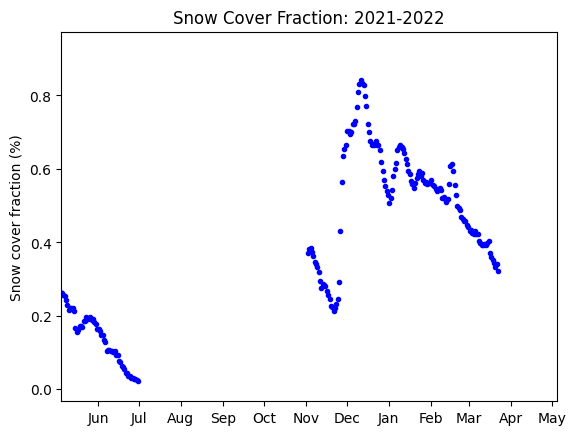

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date

# Extract observation dates and snow cover fractions from the dataframe
observation_dates = snow_cover_dataframe.index
snow_cover_fractions = snow_cover_dataframe['snow_cover_fraction']

# Plot snow cover fractions against observation dates
plt.plot(observation_dates, snow_cover_fractions, marker='.', linestyle='none', color='blue', label='Snow Cover Fraction')

# Set the x-axis limits
start_date = date(2021, 5, 5)
end_date = date(2022, 5, 5)
plt.xlim([start_date, end_date])

# Set the title and y-axis label
plt.title('Snow Cover Fraction: 2021-2022')
plt.ylabel('Snow cover fraction (%)')

# Configure x-axis to show months
current_axis = plt.gca()
current_axis.xaxis.set_major_locator(mdates.MonthLocator())
current_axis.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Display the plot
plt.show()

In [ ]:
import numpy as np
y = snow_cover_dataframe.snow_cover_fraction
print('y dimensions:',y.shape)

y dimensions: (5160,)


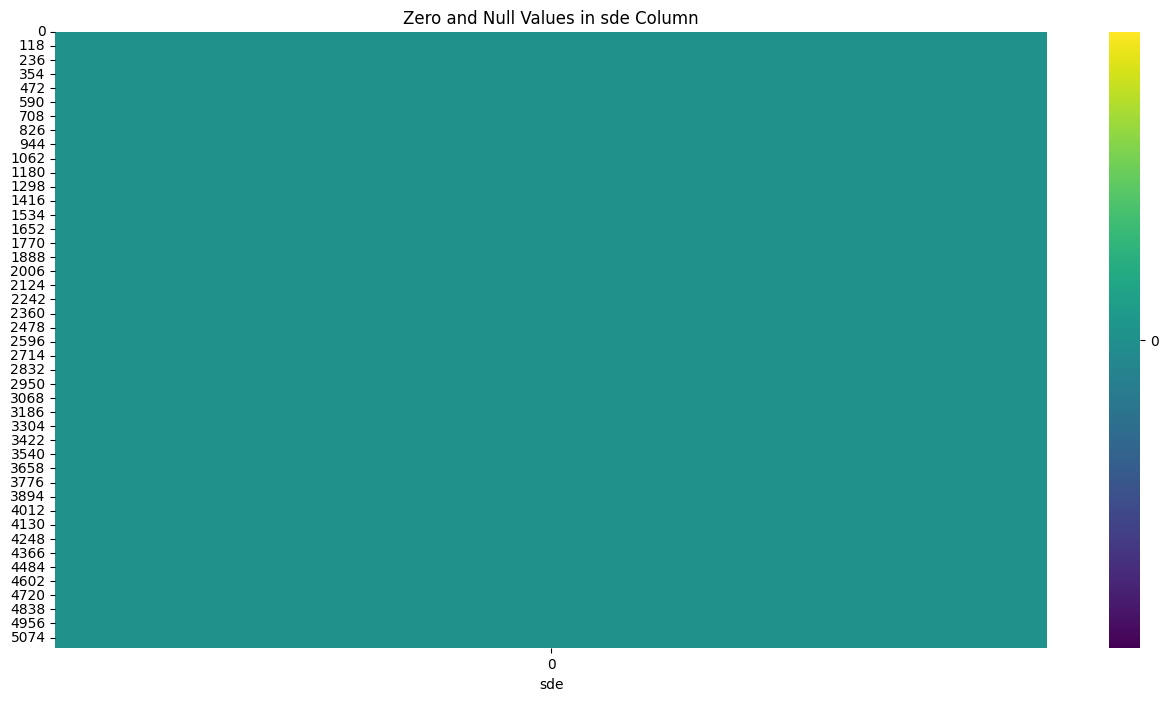

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a Series with the same shape as df.sde
combined_sde = pd.Series(index=y.index)

# Mark NaNs with 2
combined_sde[y.isna()] = 2

# Mark zeros with 1
combined_sde[y < 0] = 1

# Fill remaining spots with 0
combined_sde.fillna(0, inplace=True)

# Plot the heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(combined_sde.values.reshape(-1, 1), cbar=True, cmap='viridis', cbar_kws={'ticks': [0, 1, 2]})
plt.title('Zero and Null Values in sde Column')
plt.xlabel('sde')
plt.show()

In [ ]:
print("Percentage of below 0 values in the dataset: {}%".format(round(((y.isna().sum() + (y < 0).sum())/y.shape[0])*100, 4)))

Percentage of below 0 values in the dataset: 0.0%


In [ ]:
data = y.to_frame()

data.index = pd.to_datetime(data.index.date)

In [ ]:
data.index.year.min(), data.index.year.max()

(2000, 2022)

In [ ]:
data.head()

,snow_cover_fraction
2000-11-01,0.377
2000-11-02,0.372
2000-11-03,0.369
2000-11-04,0.379
2000-11-05,0.382


In [ ]:
data.tail()

,snow_cover_fraction
2022-03-18,0.353
2022-03-19,0.345
2022-03-20,0.333
2022-03-21,0.341
2022-03-22,0.321


**Filling missing days**

In [ ]:
# Checking for missing dates in the dataset
date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
missing_dates = date_range.difference(data.index)

# Displaying the missing dates
missing_dates

DatetimeIndex(['2000-12-31', '2001-06-16', '2001-06-17', '2001-06-18',
               '2001-06-19', '2001-06-20', '2001-06-21', '2001-06-22',
               '2001-06-23', '2001-06-24',
               ...
               '2021-10-23', '2021-10-24', '2021-10-25', '2021-10-26',
               '2021-10-27', '2021-10-28', '2021-10-29', '2021-10-30',
               '2021-10-31', '2021-11-01'],
              dtype='datetime64[ns]', length=2652, freq=None)

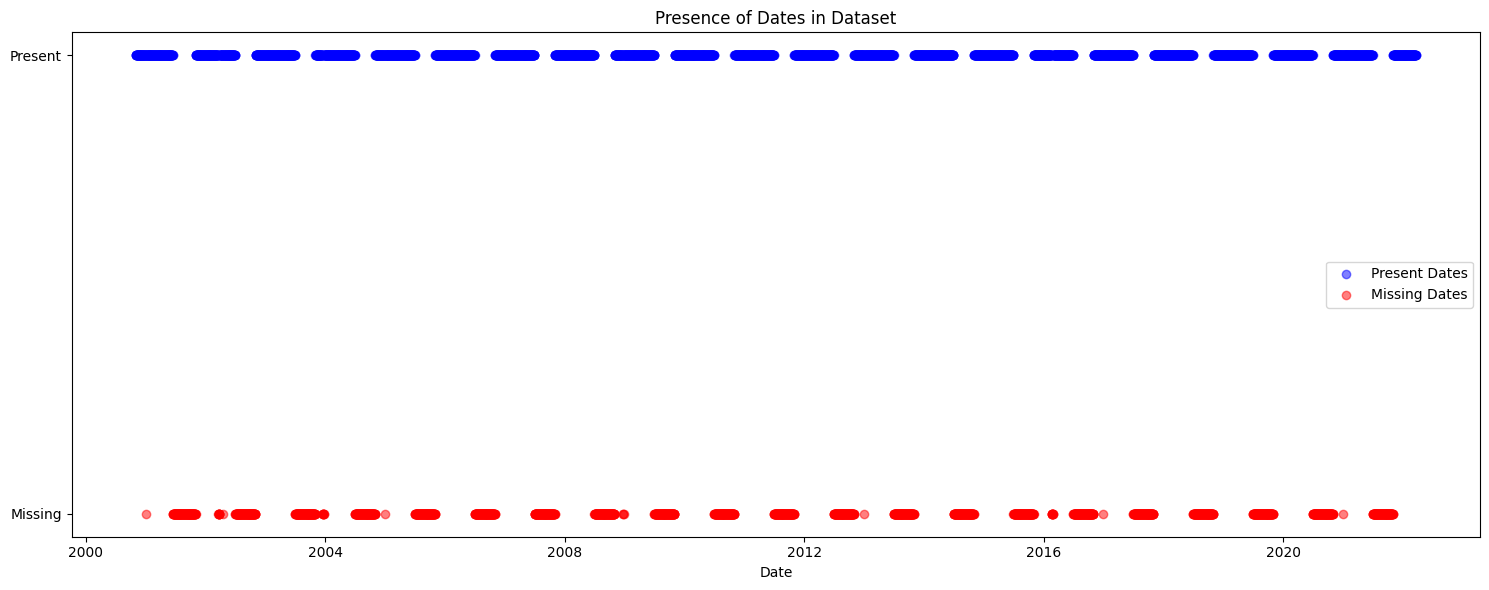

In [ ]:
import matplotlib.pyplot as plt

# Plotting the filled dates and missing dates in a graph
plt.figure(figsize=(15, 6))

# Marking the dates present in the dataset
plt.scatter(data.index, [1] * len(data), color='blue', label='Present Dates', alpha=0.5)

# Marking the missing dates
plt.scatter(missing_dates, [0] * len(missing_dates), color='red', label='Missing Dates', alpha=0.5)

plt.xlabel('Date')
plt.yticks([0, 1], ['Missing', 'Present'])
plt.title('Presence of Dates in Dataset')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Step 1: Calculate the Gap Between Missing Days
missing_dates_diff = missing_dates.to_series().diff().dt.days - 1
max_gap = missing_dates_diff.max()
max_gap_index = missing_dates_diff.idxmax()  # Timestamp index of the maximum gap
max_gap, max_gap_index

(241.0, Timestamp('2003-07-01 00:00:00'))

In [ ]:
data_interpolated = data.reindex(date_range)

for year in range(data.index.year.min(), data.index.year.max() + 1):
    summer_start = pd.Timestamp(year=year, month=6, day=21)
    summer_end = pd.Timestamp(year=year, month=9, day=22)
    summer_range = pd.date_range(start=summer_start, end=summer_end)

    # Find the last day before summer starts
    last_day_before_summer = data.loc[:summer_start - pd.Timedelta(days=1)].last_valid_index()

    if last_day_before_summer is not None:
        fill_value = data.loc[last_day_before_summer]
    else:
        fill_value = 0  # or some other default value, as needed

    # Adjust fill_value to match the shape of the data being replaced
    if isinstance(fill_value, pd.Series):
        fill_value = fill_value.values

    summer_missing = missing_dates.intersection(summer_range)
    data_interpolated.loc[summer_missing] = fill_value

data_interpolated = data_interpolated.interpolate(method='linear')

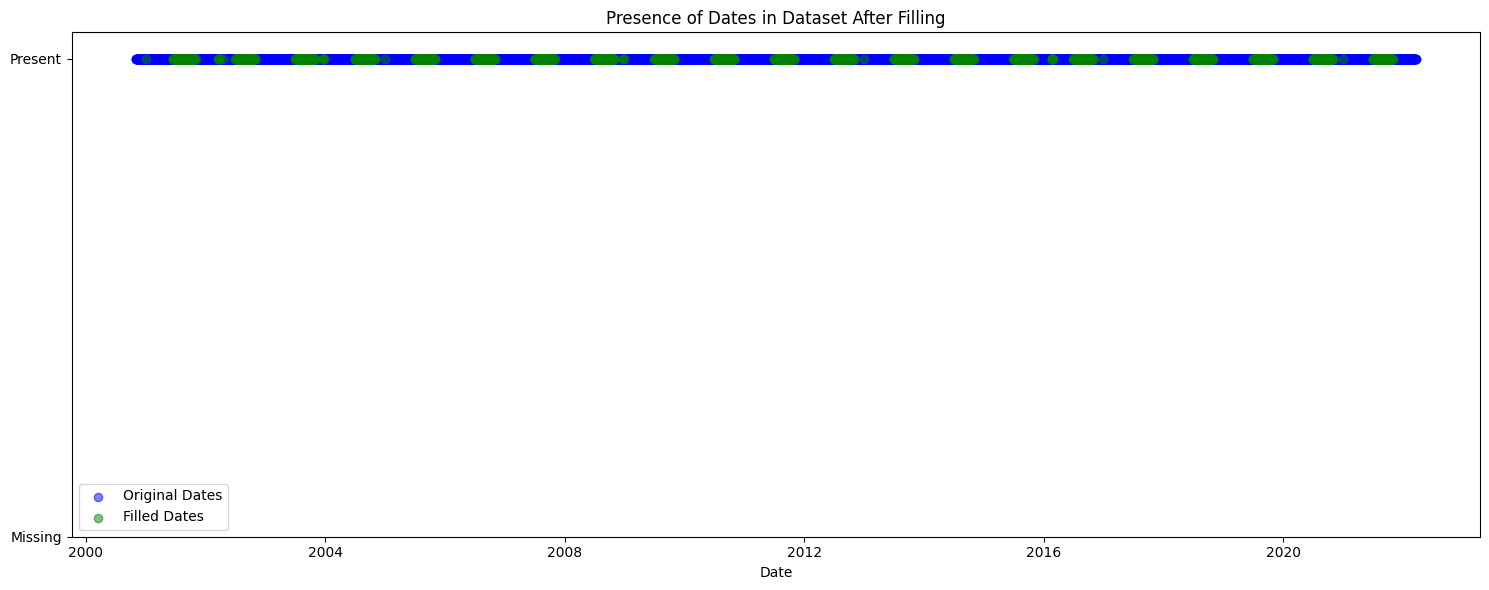

In [ ]:
# Checking if all missing dates are filled
filled_dates = data_interpolated.index.difference(data.index)

# Plotting the graph again with the filled data
plt.figure(figsize=(15, 6))

# Marking the original dates
plt.scatter(data.index, [1] * len(data), color='blue', label='Original Dates', alpha=0.5)

# Marking the filled dates
plt.scatter(filled_dates, [1] * len(filled_dates), color='green', label='Filled Dates', alpha=0.5)

plt.xlabel('Date')
plt.yticks([0, 1], ['Missing', 'Present'])
plt.title('Presence of Dates in Dataset After Filling')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Function to calculate weights
def get_weights(num_years):
    total_weight = sum(range(1, num_years + 1))
    return [i / total_weight for i in range(1, num_years + 1)][::-1]

# Number of years to look back
lookback_years = 5

# Last date in the data
last_date = data_interpolated.index[-1]

# Calculate the remaining days in the year
remaining_days = pd.date_range(start=last_date + pd.Timedelta(days=1), end=pd.Timestamp(year=last_date.year, month=12, day=31))

# DataFrame to store the extended data
extended_forecast = pd.DataFrame(index=remaining_days, columns=['snow_cover_fraction'])

for date in extended_forecast.index:
    historical_values = []
    weights = []
    for i in range(1, lookback_years + 1):
        historical_date = pd.Timestamp(year=date.year - i, month=date.month, day=date.day)
        # Check if the historical date exists in the data
        if historical_date in data_interpolated.index:
            historical_values.append(data_interpolated.loc[historical_date, 'snow_cover_fraction'])
            weights.append(i)  # Weight by the year
        else:
            print(f"No data for historical date: {historical_date}")

    # Calculate weighted average if historical values are available
    if historical_values:
        weights = np.array(weights) / sum(weights)
        weighted_avg = np.dot(historical_values, weights)
        extended_forecast.loc[date, 'snow_cover_fraction'] = weighted_avg
    else:
        print(f"No historical data available for forecast date: {date}")
        extended_forecast.loc[date, 'snow_cover_fraction'] = np.nan

# Check if any forecasted values were calculated
print("Number of non-null forecasted values:", extended_forecast['snow_cover_fraction'].notnull().sum())

# Combine the existing and forecasted data
extended_data = pd.concat([data_interpolated, extended_forecast])
extended_data.tail(155)

Number of non-null forecasted values: 284


,snow_cover_fraction
2022-07-30,0.041467
2022-07-31,0.041467
2022-08-01,0.041467
2022-08-02,0.041467
2022-08-03,0.041467
...,...
2022-12-27,0.638333
2022-12-28,0.649467
2022-12-29,0.645067
2022-12-30,0.643667


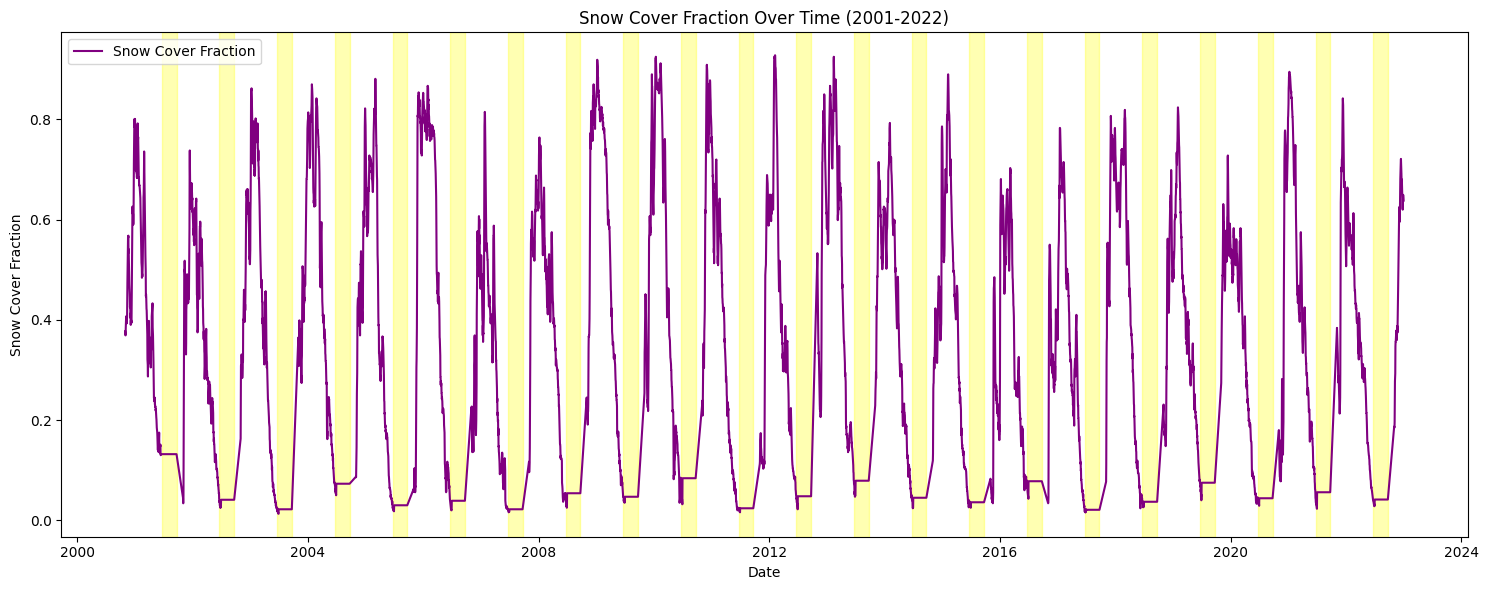

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'extended_data' is your DataFrame and it has a DateTime index
# Define the summer period for each year in your dataset
start_month, start_day = 6, 21  # June 21
end_month, end_day = 9, 22      # September 22

summer_periods = []

for year in range(extended_data.index.year.min(), extended_data.index.year.max() + 1):
    summer_start = pd.Timestamp(year=year, month=start_month, day=start_day)
    summer_end = pd.Timestamp(year=year, month=end_month, day=end_day)
    if summer_start in extended_data.index and summer_end in extended_data.index:
        summer_periods.append((summer_start, summer_end))

# Plotting the whole dataset
plt.figure(figsize=(15, 6))
plt.plot(extended_data, label='Snow Cover Fraction', color='purple')

# Highlighting summer days
for start, end in summer_periods:
    plt.axvspan(start, end, color='yellow', alpha=0.3)

plt.xlabel('Date')
plt.ylabel('Snow Cover Fraction')
plt.title('Snow Cover Fraction Over Time (2001-2022)')
plt.legend()
plt.tight_layout()
plt.show()

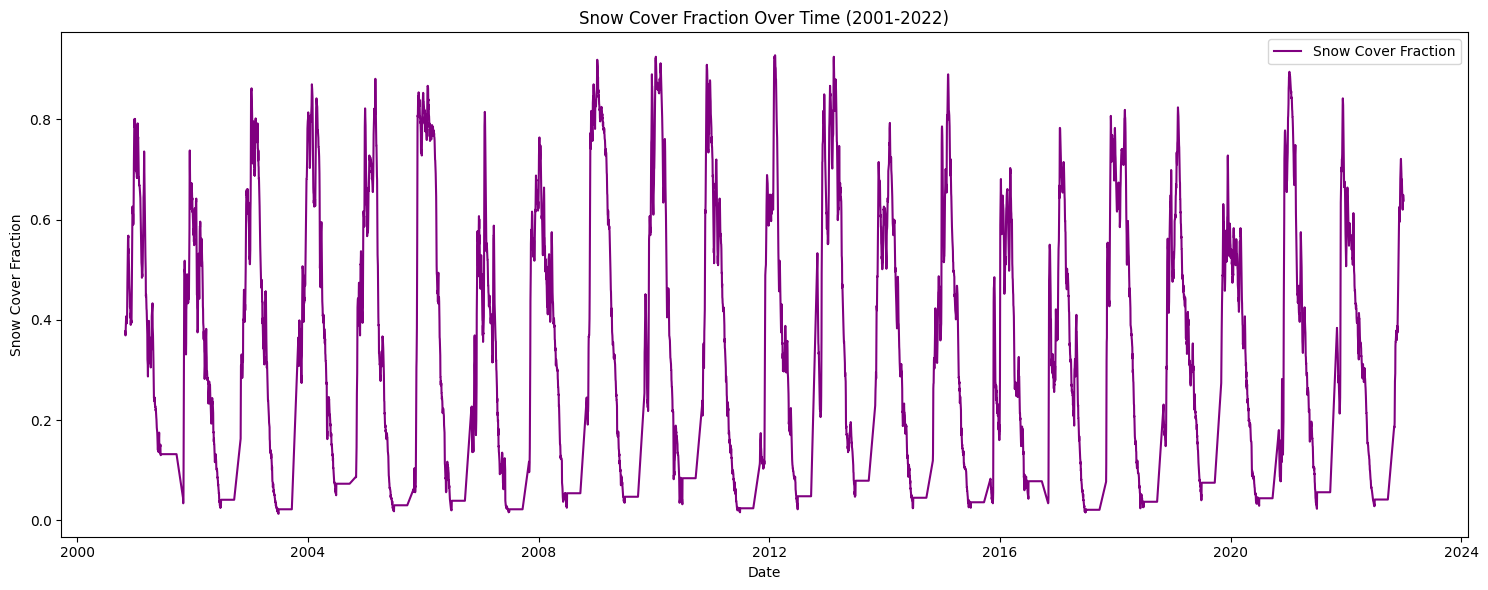

In [ ]:
import matplotlib.pyplot as plt

# Plotting the whole dataset
plt.figure(figsize=(15, 6))
plt.plot(extended_data, label='Snow Cover Fraction', color='purple')
plt.xlabel('Date')
plt.ylabel('Snow Cover Fraction')
plt.title('Snow Cover Fraction Over Time (2001-2022)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
extended_data.min()

snow_cover_fraction    0.013
dtype: object

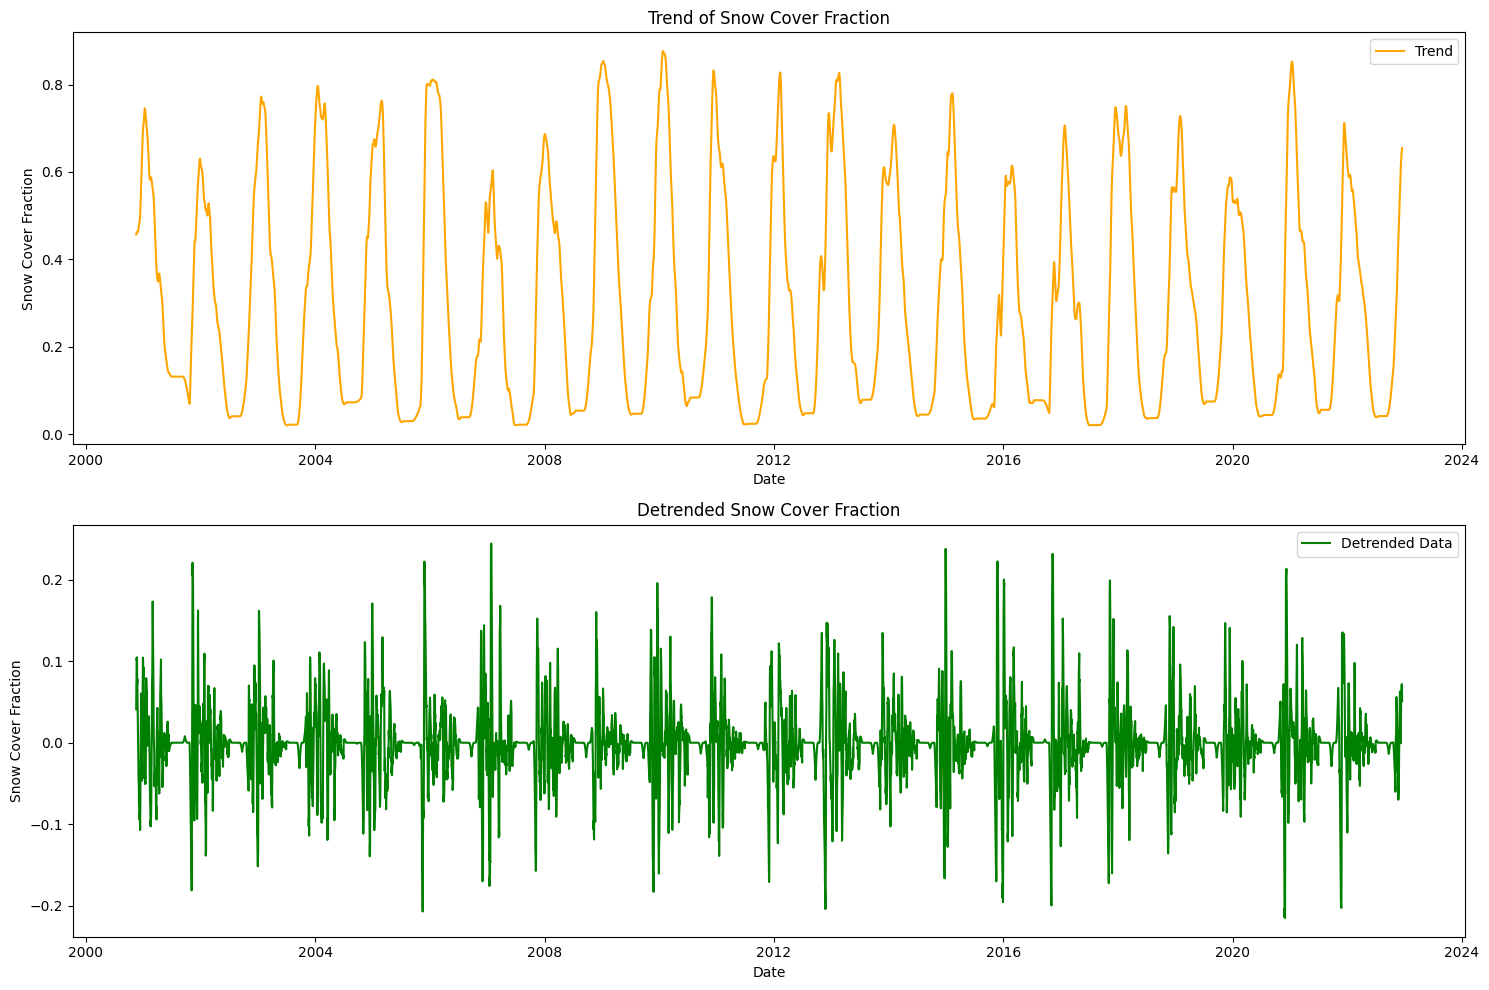

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Decomposing the data to extract the trend
decomposition = seasonal_decompose(extended_data, model='additive', period=30)
trend = decomposition.trend

# Detrending the data by subtracting the trend from the original data
detrended_data = extended_data['snow_cover_fraction'] - trend

# Dropping NaN values for plotting
trend = trend.dropna()
detrended_data = detrended_data.dropna()

# Plotting the trend and the detrended data
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# Plotting the trend
axes[0].plot(trend, label='Trend', color='orange')
axes[0].set_title('Trend of Snow Cover Fraction')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Snow Cover Fraction')
axes[0].legend()

# Plotting the detrended data
axes[1].plot(detrended_data, label='Detrended Data', color='green')
axes[1].set_title('Detrended Snow Cover Fraction')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Snow Cover Fraction')
axes[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
# Import your chosen model here

def count_leap_years(years):
    """ Counts the number of leap years in a given array of years. """
    return sum(1 for year in years if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0))

# Convert the trend data to an array for easier manipulation
trend_array = trend.dropna()

# Prepare data for rolling window approach
X, y = [], []
start_year = trend_array.index.year[0]
for start_idx in range(len(trend_array)):
    # Adjusting for a 10-year training period
    end_year = start_year + 10
    if end_year > trend_array.index.year[-1]:
        break

    # Count the number of leap years in the 10-year window
    leap_years = count_leap_years(range(start_year, end_year))

    # Adjust the window size to account for leap years in 10 years
    window_size = 10 * 365 + leap_years
    prediction_horizon = 3650 + count_leap_years(range(end_year, end_year + 10))  # 10 years including leap years

    if start_idx + window_size + prediction_horizon > len(trend_array):
        break

    X.append(trend_array[start_idx:start_idx + window_size].to_numpy())
    y.append(trend_array[start_idx + window_size:start_idx + window_size + prediction_horizon].to_numpy())

    start_year += 1

X = np.array(X, dtype=object)
y = np.array(y, dtype=object)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example: Assuming each element in X is a sequence (e.g., list or array)
# Pad the sequences in X so they all have the same length
max_length_X = max(len(sequence) for sequence in X)
max_length_y = max(len(sequence) for sequence in y)
X_padded = pad_sequences(X, maxlen=max_length_X, padding='post', dtype='float32')
y_padded = pad_sequences(y, maxlen=max_length_y, padding='post', dtype='float32')

# Reshape for LSTM: [samples, timesteps, features]
X_lstm = X_padded.reshape((X_padded.shape[0], max_length_X, 1))

In [ ]:
!pip install --upgrade numpy pandas scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Function to create a more complex LSTM model
def create_model(neurons=100, activation='relu', dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(neurons, activation=activation, return_sequences=True, input_shape=(max_length_X, 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(neurons//2, activation=activation))
    model.add(Dropout(dropout_rate//2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Parameters for pseudo grid search
param_grid = {
    'neurons': [100, 50],
    'activation': ['relu', 'tanh'],
    'dropout_rate': [0.2, 0.3]
}

# Wrap the model so it can be used by scikit-learn
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=2)

# Grid search for model tuning
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_lstm, y_padded)  # Assuming X and y are your dataset prepared for LSTM

# Best parameters from grid search
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-43-a672b87936ee>:12: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=2)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
12 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
-----------------------------------------------------------------------------

Epoch 1/10
1/1 - 8s - loss: 0.1538 - 8s/epoch - 8s/step
Epoch 2/10
1/1 - 5s - loss: 0.1434 - 5s/epoch - 5s/step
Epoch 3/10
1/1 - 4s - loss: 0.1345 - 4s/epoch - 4s/step
Epoch 4/10
1/1 - 4s - loss: 0.1265 - 4s/epoch - 4s/step
Epoch 5/10
1/1 - 5s - loss: 0.1189 - 5s/epoch - 5s/step
Epoch 6/10
1/1 - 4s - loss: 0.1118 - 4s/epoch - 4s/step
Epoch 7/10
1/1 - 4s - loss: 0.1048 - 4s/epoch - 4s/step
Epoch 8/10
1/1 - 5s - loss: 0.0979 - 5s/epoch - 5s/step
Epoch 9/10
1/1 - 4s - loss: 0.0908 - 4s/epoch - 4s/step
Epoch 10/10
1/1 - 4s - loss: 0.0841 - 4s/epoch - 4s/step
Best: nan using {'activation': 'relu', 'dropout_rate': 0.2, 'neurons': 100}


In [ ]:
# Proceed with the best parameters for a more complex forecast
best_model = create_model(neurons=grid_result.best_params_['neurons'],
                          activation=grid_result.best_params_['activation'],
                          dropout_rate=grid_result.best_params_['dropout_rate'])

# Display model summary
best_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 3653, 100)         40800     
                                                                 
 dropout_13 (Dropout)        (None, 3653, 100)         0         
                                                                 
 lstm_17 (LSTM)              (None, 50)                30200     
                                                                 
 dropout_14 (Dropout)        (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = best_model.fit(X_lstm, y_padded, epochs=25, batch_size=32)

Epoch 1/30
1/1 [==============================] - 6s 6s/step - loss: 0.1442
Epoch 2/30
1/1 [==============================] - 5s 5s/step - loss: 0.1357
Epoch 3/30
1/1 [==============================] - 5s 5s/step - loss: 0.1280
Epoch 4/30
1/1 [==============================] - 4s 4s/step - loss: 0.1207
Epoch 5/30
1/1 [==============================] - 4s 4s/step - loss: 0.1135
Epoch 6/30
1/1 [==============================] - 7s 7s/step - loss: 0.1066
Epoch 7/30
1/1 [==============================] - 4s 4s/step - loss: 0.0994
Epoch 8/30
1/1 [==============================] - 4s 4s/step - loss: 0.0923
Epoch 9/30
1/1 [==============================] - 5s 5s/step - loss: 0.0844
Epoch 10/30
1/1 [==============================] - 5s 5s/step - loss: 0.0767
Epoch 11/30
1/1 [==============================] - 4s 4s/step - loss: 0.0696
Epoch 12/30
1/1 [==============================] - 4s 4s/step - loss: 0.0642
Epoch 13/30
1/1 [==============================] - 5s 5s/step - loss: 0.0607
Epoch 14

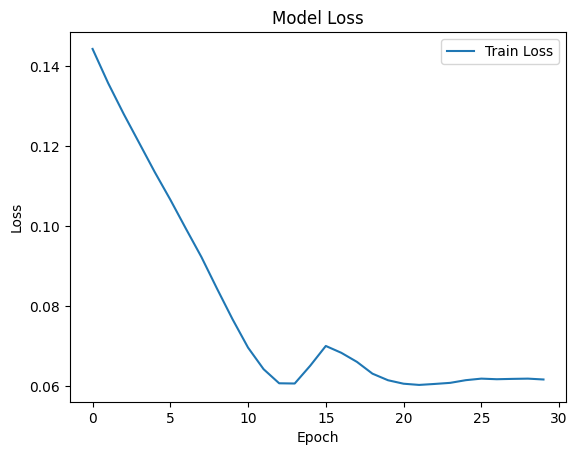

In [ ]:
# Plotting training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# Assuming you have the correct prediction horizon
prediction_horizon = max_length_y  # Adjust this as per your model's output

# Select the last 5 years of data for testing (adjust according to the prediction horizon)
test_data = trend.last('5Y')[-prediction_horizon:]

<ipython-input-53-44040b76ed82>:5: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  test_data = trend.last('5Y')[-prediction_horizon:]


In [ ]:
# Check if the last 5 years have enough data, if not, adjust the period
if len(test_data) < prediction_horizon:
    # Adjust the period to match the prediction horizon
    test_data = trend[-prediction_horizon:]

# Pad and reshape the test data
test_data_padded = pad_sequences([test_data.values], maxlen=max_length_X, padding='post', dtype='float32')
test_data_lstm = test_data_padded.reshape((1, max_length_X, 1))

# The true values (y) for evaluation
true_values = test_data.values.reshape((1, prediction_horizon))

# Evaluate the model
model_evaluation = best_model.evaluate(test_data_lstm, true_values, verbose=0)

print("Model Evaluation (Loss) on the selected test data segment:", model_evaluation)

Model Evaluation (Loss) on the selected test data segment: 0.05760720744729042


1/1 [==============================] - 1s 701ms/step


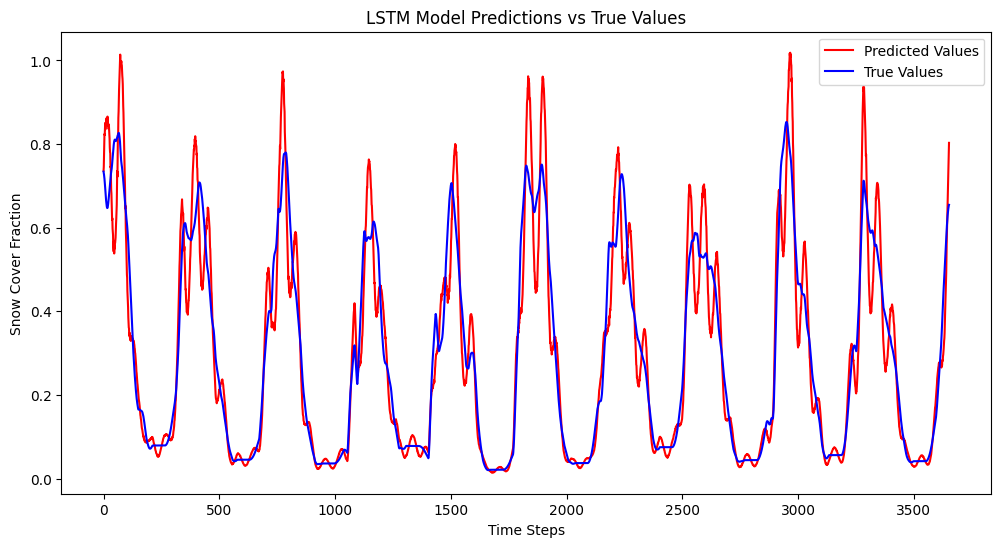

In [ ]:
import matplotlib.pyplot as plt

# Generate predictions for the test data
predictions = best_model.predict(test_data_lstm)

# Flatten the predictions to match the true values' shape
predictions_flat = predictions.flatten()

# Plot the predictions and the true values
plt.figure(figsize=(12, 6))
plt.plot(predictions_flat, label='Predicted Values', color='red')
plt.plot(true_values.flatten(), label='True Values', color='blue')
plt.title('LSTM Model Predictions vs True Values')
plt.xlabel('Time Steps')
plt.ylabel('Snow Cover Fraction')
plt.legend()
plt.show()

In [ ]:
def nash_sutcliffe_efficiency(true_values, predicted_values):
    """
    Calculate the Nash-Sutcliffe efficiency coefficient.
    :param true_values: Array of true values.
    :param predicted_values: Array of predicted values.
    :return: Nash-Sutcliffe efficiency coefficient.
    """
    mean_observed = np.mean(true_values)
    numerator = np.sum((predicted_values - true_values) ** 2)
    denominator = np.sum((true_values - mean_observed) ** 2)
    return 1 - (numerator / denominator)

# Calculate Nash-Sutcliffe efficiency
nse = nash_sutcliffe_efficiency(true_values.flatten(), predictions_flat)
print(f"Nash-Sutcliffe Efficiency: {nse}")

Nash-Sutcliffe Efficiency: 0.8729770185671489


In [ ]:
look_back = 3653
# Sliding window prediction for the next 10 years
predicted = []

# Convert the Pandas Series to a NumPy array
current_batch = trend[-look_back:].to_numpy()
current_batch = current_batch.reshape((1, look_back, 1))

In [ ]:
# Replicate the last five years of data for a ten-year forecast
last_ten_years = trend.last('10Y')

pred_val = []
for i in range(3653): # 10 years * 365 days + 3 (leap years)
    current_pred = best_model.predict(current_batch)[0]
    pred_val.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

if len(pred_val) > 3653:
    pred_val = pred_val[:3653]

# Generating new dates for the ten-year forecast period
forecast_start_date = last_ten_years.index[-1] + pd.Timedelta(days=1)
forecast_end_date = forecast_start_date + pd.DateOffset(years=10)
forecast_dates = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='D')[:len(pred_val)]

# Ensure the forecast data aligns with the new dates
forecast_data = pd.Series(data=pred_val, index=forecast_dates)

1/1 [==============================] - 1s 684ms/step


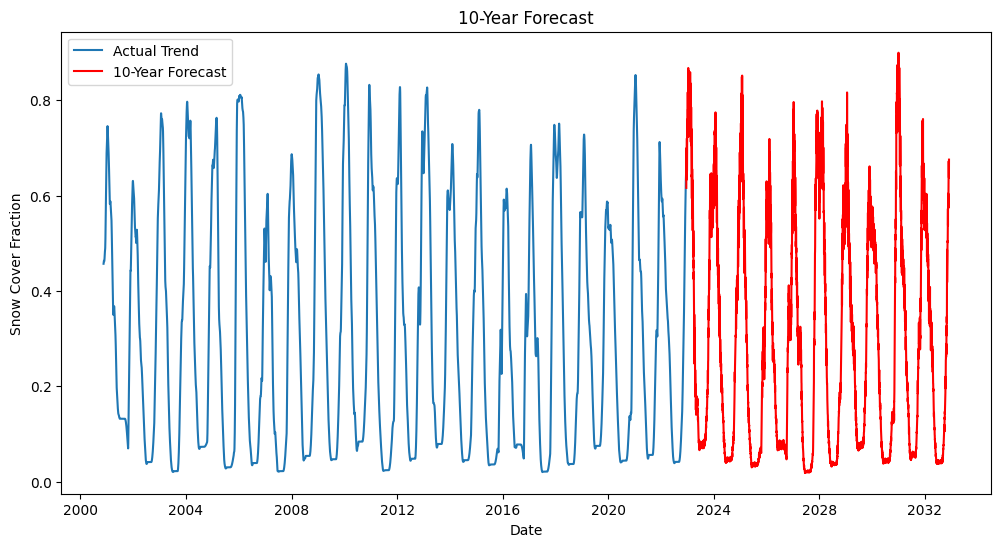

In [ ]:
# Plotting the forecast alongside the actual trend
plt.figure(figsize=(12, 6))
plt.plot(trend.index, trend, label='Actual Trend')
plt.plot(forecast_data.index, forecast_data, label='10-Year Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Snow Cover Fraction')
plt.title('10-Year Forecast')
plt.legend()
plt.show()

In [ ]:
# Save the LSTM model
best_model.save('./lstm_base_model.h5')

# Combining the original trend data with the forecast data
extended_dataset = pd.concat([trend, forecast_data])
extended_dataset.index.name = 'date'
extended_dataset.name = 'snow_cover_fraction'

# Save the extended dataset as a CSV file
extended_dataset.to_csv('./French_extended_dataset.csv', header=True)

## Detrended data pretrain

In [ ]:
detrended_data.head()

2000-11-16       0.041
2000-11-17    0.070267
2000-11-18      0.0784
2000-11-19     0.10405
2000-11-20    0.101117
Freq: D, dtype: object

In [ ]:
detrended_data.tail()

2022-12-12    0.065997
2022-12-13     0.07042
2022-12-14    0.071941
2022-12-15    0.059341
2022-12-16    0.051112
Freq: D, dtype: object

In [ ]:
# Function to create dataset for GRU
def create_dataset(data, look_back=365):
    X, Y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)


In [ ]:
# Create the dataset for GRU
values = detrended_data.values.reshape(-1, 1)
X, y = create_dataset(values)

In [ ]:
# Splitting data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Reshape input for GRU
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [ ]:
from tensorflow.keras.layers import GRU, Dense, Dropout


# Building the GRU model
model = Sequential(name="GRU")
model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(GRU(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 365, 50)           7950      
                                                                 
 dropout_2 (Dropout)         (None, 365, 50)           0         
                                                                 
 gru_3 (GRU)                 (None, 50)                15300     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 23301 (91.02 KB)
Trainable params: 23301 (91.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

Epoch 1/5
193/193 [==============================] - 77s 360ms/step - loss: 5.9147e-04 - val_loss: 2.4635e-04
Epoch 2/5
193/193 [==============================] - 64s 334ms/step - loss: 3.1248e-04 - val_loss: 1.7678e-04
Epoch 3/5
193/193 [==============================] - 63s 326ms/step - loss: 2.5781e-04 - val_loss: 1.6472e-04
Epoch 4/5
193/193 [==============================] - 63s 328ms/step - loss: 2.5136e-04 - val_loss: 1.7167e-04
Epoch 5/5
193/193 [==============================] - 64s 329ms/step - loss: 2.4599e-04 - val_loss: 1.5824e-04


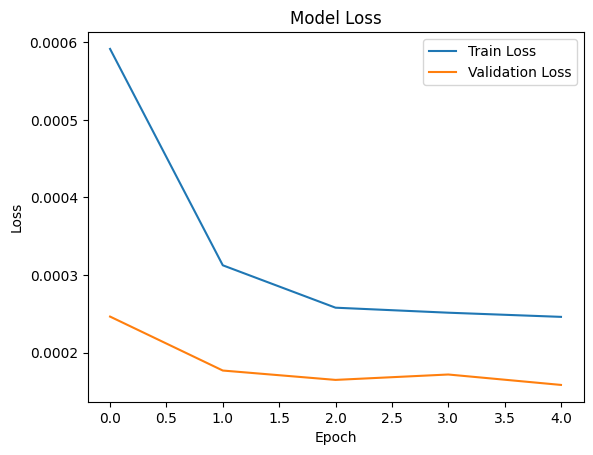

In [ ]:
# Plotting training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# Forecasting future values
future_steps = 365 * 10 + 3
forecast = []
last_input = X_test[-1]

In [ ]:
detrended_dataframe = detrended_data.to_frame(name='snow_cover_fraction')

current_date = detrended_dataframe.index[-1] + pd.Timedelta(days=1)
for i in range(future_steps):
    prediction = model.predict(last_input.reshape(1, -1, 1))[0, 0]
    forecast.append(prediction)
    last_input = np.roll(last_input, -1)
    last_input[-1] = prediction

1/1 [==============================] - 0s 46ms/step


In [ ]:
# Replicate the last five years of data for a ten-year forecast
last_ten_years = trend.last('10Y')

# Generating new dates for the ten-year forecast period
forecast_start_date = last_ten_years.index[-1] + pd.Timedelta(days=1)
forecast_end_date = forecast_start_date + pd.DateOffset(years=10)
forecast_dates = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='D')[:len(forecast)]

# Ensure the forecast data aligns with the new dates
forecast_data = pd.Series(data=forecast, index=forecast_dates)

<ipython-input-68-c29b24fbf547>:2: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_ten_years = trend.last('10Y')


In [ ]:
forecast_data.head()

2022-12-17    0.095700
2022-12-18    0.079236
2022-12-19    0.057690
2022-12-20    0.043393
2022-12-21    0.033601
Freq: D, dtype: float64

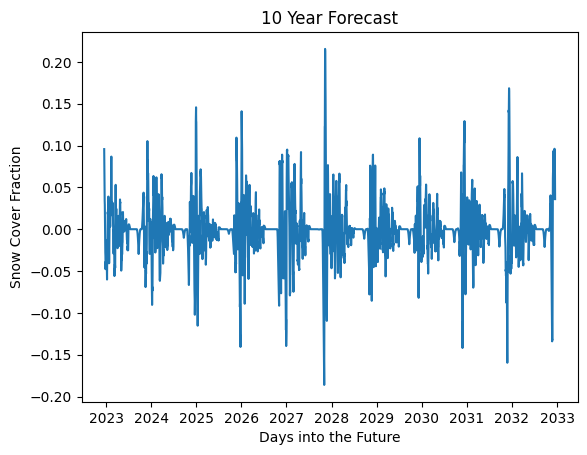

In [ ]:
# Visualizing the forecast
plt.plot(forecast_data.index, forecast_data.values)
plt.title('10 Year Forecast')
plt.ylabel('Snow Cover Fraction')
plt.xlabel('Days into the Future')
plt.show()

In [ ]:
# Save the GRU model
model.save('./gru_base_model.h5')

# Combining the original trend data with the forecast data
extended_dataset = pd.concat([detrended_data, forecast_data])
extended_dataset.index.name = 'date'
extended_dataset.name = 'snow_cover_fraction'

# Save the extended dataset as a CSV file
extended_dataset.to_csv('./French_extended_dataset_detrended.csv', header=True)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Full French Data**

In [ ]:
trend = pd.read_csv('./French_extended_dataset.csv', index_col='date', parse_dates=True)
detrend = pd.read_csv('./French_extended_dataset_detrended.csv', index_col='date', parse_dates=True)

In [ ]:
trend.rename(columns={'snow_cover_fraction': 'trend'}, inplace=True)
trend.head()

,trend
date,
2000-11-16,0.457000
2000-11-17,0.458733
2000-11-18,0.460600
2000-11-19,0.461950
2000-11-20,0.462883


In [ ]:
detrend.rename(columns={'snow_cover_fraction': 'detrend'}, inplace=True)
detrend.head()

,detrend
date,
2000-11-16,0.041000
2000-11-17,0.070267
2000-11-18,0.078400
2000-11-19,0.104050
2000-11-20,0.101117


In [ ]:
merged_df = pd.merge(trend, detrend, left_index=True, right_index=True)
merged_df.head()

,trend,detrend
date,,
2000-11-16,0.457000,0.041000
2000-11-17,0.458733,0.070267
2000-11-18,0.460600,0.078400
2000-11-19,0.461950,0.104050
2000-11-20,0.462883,0.101117


In [ ]:
merged_df['snow_cover_fraction'] = merged_df['trend'] + merged_df['detrend']
merged_df.head()

,trend,detrend,snow_cover_fraction
date,,,
2000-11-16,0.457000,0.041000,0.498
2000-11-17,0.458733,0.070267,0.529
2000-11-18,0.460600,0.078400,0.539
2000-11-19,0.461950,0.104050,0.566
2000-11-20,0.462883,0.101117,0.564


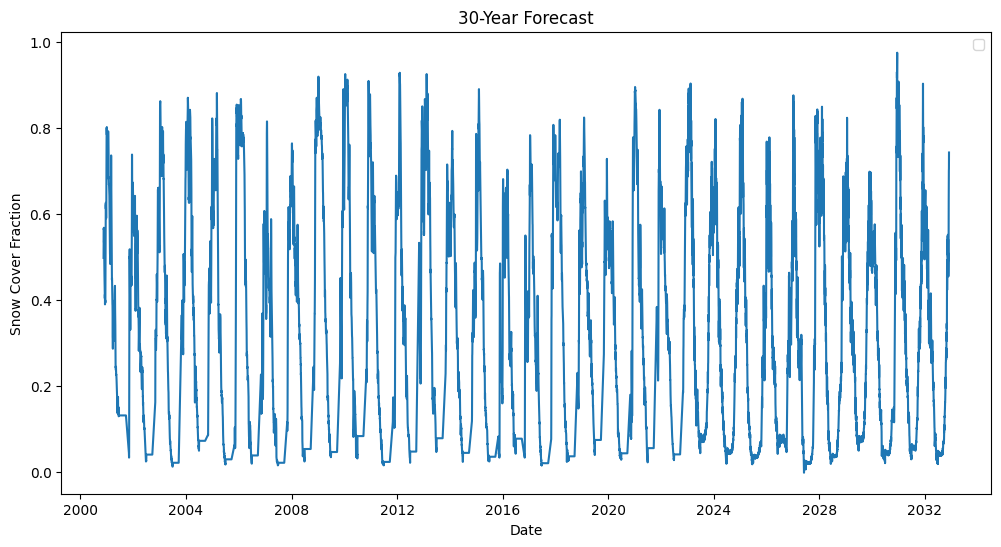

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index, merged_df.snow_cover_fraction)
plt.xlabel('Date')
plt.ylabel('Snow Cover Fraction')
plt.title('30-Year Forecast')
plt.legend()
plt.show()

In [ ]:
merged_df.to_csv('./French_merged_dataset.csv', header=True)